# Installs, Imports, Preps

In [ ]:
%%capture
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers
!pip install yacs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Shareddrives/cis630/CoOp

/content/drive/Shareddrives/cis630/CoOp


In [ ]:
import clip
import torch
import transformers
import torchvision
import gc
import os

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset

from tqdm import tqdm
from config import get_cfg_defaults

import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
cfg = get_cfg_defaults()

# if not os.path.exists('checkpoints'):
#     os.mkdir('checkpoints')

# CLIP Model

In [ ]:
print(f"Loading {cfg.MODEL.NAME}")
model, transform = clip.load(cfg.MODEL.NAME)
model.to(device)
print(f"Model in {device}")

Loading RN50


100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 56.7MiB/s]


Model in cuda


# Image Encoding

## Load data

In [ ]:
# If download is necessary, use this
dataset = torchvision.datasets.Flowers102(root='',transform=transform,download=True,split='train')

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

In [ ]:
'''GPU constrained (avoid OOM error)'''
subsets = [Subset(dataset, range(i,i+204)) for i in range(0, len(dataset), len(dataset)//5)]
dataloaders = [DataLoader(subset, batch_size=16, shuffle=False) for subset in subsets]

## Get image embs

Confirm image shape

In [ ]:
print(f"Image shape: {dataset[0][0].shape}")
print(f"Label type:  {type(dataset[0][1])}")

Image shape: torch.Size([3, 224, 224])
Label type:  <class 'int'>


Encode

In [ ]:
def free_gpu_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
for i,dataloader in enumerate(dataloaders):
    img_embs, lbls = [], []
    for images, labels in tqdm(dataloader):
        img_embs.append(model.encode_image(images.to(device)))
        lbls.append(labels)
    free_gpu_cache()
    img_embs, lbls = torch.vstack(img_embs), torch.hstack(lbls)
    print(f"Image embedding shape: {img_embs.shape}")
    print(f"Labels shape:          {lbls.shape}")
    torch.save(img_embs, f'checkpoints/{cfg.DATASET.NAME}_image_embs_{i}.pt')
    torch.save(lbls,     f'checkpoints/{cfg.DATASET.NAME}_labels_{i}.pt')

100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


Image embedding shape: torch.Size([204, 1024])
Labels shape:          torch.Size([204])


100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


Image embedding shape: torch.Size([204, 1024])
Labels shape:          torch.Size([204])


100%|██████████| 13/13 [00:03<00:00,  3.38it/s]


Image embedding shape: torch.Size([204, 1024])
Labels shape:          torch.Size([204])


100%|██████████| 13/13 [00:02<00:00,  4.70it/s]


Image embedding shape: torch.Size([204, 1024])
Labels shape:          torch.Size([204])


100%|██████████| 13/13 [00:02<00:00,  4.72it/s]


Image embedding shape: torch.Size([204, 1024])
Labels shape:          torch.Size([204])


Aggregate temp files

In [ ]:
# img_embs = torch.vstack([torch.load(f'checkpoints/{cfg.DATASET.NAME}_image_embs_{i}.pt') for i in range(len(dataloaders))])
# lbls = torch.hstack([torch.load(f'checkpoints/{cfg.DATASET.NAME}_labels_{i}.pt') for i in range(len(dataloaders))])

Save for future use

In [ ]:
torch.save(img_embs, f'checkpoints/{cfg.DATASET.NAME}_image_embs.pt')
torch.save(lbls,     f'checkpoints/{cfg.DATASET.NAME}_labels.pt')

# Required function

## nShot dataset creation 

In [ ]:
def subset_train(image_embeddings,labels,nshot,index,n_classes,per_class=10):
    np.random.seed(1)
    # randomly choose nshot data points from rest of the data
    index_new = np.array([np.random.choice(list(set(j)-set(index)),nshot,replace=False) for j in [np.arange(i,i+per_class) for i in range(0,labels.shape[0],int(labels.shape[0]/n_classes))]]).flatten()
    '''Train set'''
    train_label = labels[index_new]
    train_img_emb = image_embeddings[index_new]
    print("Train set: ",train_img_emb.shape, train_label.shape)

    # randomize train data
    index_new = torch.randperm(train_img_emb.size(0))
    train_img_emb = train_img_emb[index_new]
    train_label = train_label[index_new]
    return [train_img_emb, train_label]


def subset_data(image_embeddings,labels,nshot = 8,test_size = 2,n_classes = len(cfg.DATASET.CLASSNAMES), per_class = 10 ):
  '''
  Function to subset nshots from Flower Dataset
  '''
  # Create Test set
  # randomly choose test_size data points from data
  np.random.seed(1)
  index = np.array([np.random.choice(j,test_size,replace=False) for j in [np.arange(i,i+per_class) for i in range(0,labels.shape[0],int(labels.shape[0]/n_classes))]]).flatten()
  '''Test set'''
  test_label = labels[index]
  test_img_emb = image_embeddings[index]
  print("Test set: ",test_img_emb.shape, test_label.shape)

  if type(nshot) != list:
    train_img_emb, train_label = subset_train(image_embeddings,labels,nshot,index,n_classes,per_class,)
    return (train_img_emb, train_label, test_img_emb,test_label)
  
  else:
    train = {}
    for n in nshot:
      train[n] = subset_train(image_embeddings,labels,n,index,n_classes,per_class)
    return (train,test_img_emb,test_label)
  

## Train - Test 

In [ ]:
def train(model, data, eval_data, criterion, optimizer, scheduler, n_epoch):
  model.train()
  print('-'*20,'Train results','-'*20)
  for epoch in range(n_epoch):
      running_loss = 0.0
      running_corr = 0
      ndata = 0 
      
      for batch in data:
          img_embs, lbls = batch[0].to(device), batch[1].to(device)
          outputs = model(img_embs)
          loss = criterion(outputs, lbls)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          preds = torch.argmax(outputs, dim=1)
          running_loss += loss.item()
          running_corr += torch.sum(preds==lbls.data)
          ndata += img_embs.size(0)

      epoch_loss = running_loss / ndata
      epoch_acc = 100*running_corr.double() / ndata
      if epoch==0 or (epoch+1)%5==0:
        print(f"\nEpoch {epoch+1}/{n_epoch}:")
        print('-' * 20)
        print('loss: {:.4f}; acc: {:.4f} %'.format(epoch_loss, np.round(epoch_acc.item(),2)))
      
      scheduler.step()
      
  model.eval()
  running_loss = 0.0
  running_corr = 0
  ndata = 0 

  print('\n','-'*20,'Eval results','-'*20)
  for batch in eval_data:
      img_embs, lbls = batch[0].to(device), batch[1].to(device)
      outputs = model(img_embs)
      loss = criterion(outputs, lbls)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      preds = torch.argmax(outputs, dim=1)
      running_loss += loss.item()
      running_corr += torch.sum(preds==lbls.data)
      ndata += img_embs.size(0)

  epoch_loss = running_loss / ndata
  epoch_acc = 100*running_corr.double() / ndata
  print('loss: {:.4f}; acc: {:.4f}'.format(epoch_loss, np.round(epoch_acc.item(),2)))
  scheduler.step()


# Context Optimization 

## Prompt Learner - CoOp

In [ ]:
class CoOp(nn.Module):
    def __init__(self, cfg, model, device):
        super().__init__()
        self.n_cls = len(cfg.DATASET.CLASSNAMES)
        self.n_ctx = cfg.TRAIN.N_CTX
        ctx_dim = model.ln_final.weight.shape[0] #512
        
        # A prompt in CoOp with classname at the back looks like: [SOS][V1]...[Vn][CLS][EOS]
        # Assume classname is always at the back for now.

        # context init
        if cfg.TRAIN.CTX_INIT:
            # fixed init (assume global ctx)
            ctx_init = cfg.TRAIN.CTX_INIT.replace("_", " ") # The "_" is for fill-in of class name
            with torch.no_grad():
                token_emb = model.token_embedding(clip.tokenize(ctx_init).to(device)).type(model.dtype)
            ctx_vectors = token_emb[0, 1:self.n_ctx+1, :]
            prefix = ctx_init
        else:
            # random init
            if cfg.TRAIN.CSC:
                # class-specific ctx
                ctx_vectors = torch.empty(self.n_cls, self.n_ctx, ctx_dim, dtype=model.dtype)
            else:
                # global ctx
                ctx_vectors = torch.empty(self.n_ctx, ctx_dim, dtype=model.dtype)
            nn.init.normal_(ctx_vectors, std=cfg.TRAIN.PARAM_STD)
            prefix = " ".join(["X"]*self.n_ctx)
        
        # context vectors (THE ONLY PART THAT NEEDS TO BE TRAINED)
        self.ctx = nn.Parameter(ctx_vectors)
        
        # prompt finalization
        classnames = [classname.replace("_", " ") for classname in cfg.DATASET.CLASSNAMES]
        raw_prompts = [prefix + " " + classname + "." for classname in classnames]
        self.tokenized_prompts = torch.cat([clip.tokenize(raw_prompt).to(device) for raw_prompt in raw_prompts])
        # print(self.tokenized_prompts.get_device())
        with torch.no_grad():
            token_emb = model.token_embedding(self.tokenized_prompts).type(model.dtype)
        
        # [SOS]
        self.register_buffer("prefix", token_emb[:, :1, :])
        # [CLS][EOS]
        self.register_buffer("suffix", token_emb[:, self.n_ctx+1:, :])

        
    def forward(self):
        # expand global ctx to match n_cls (i.e., a total of n_cls ctx vectors)
        ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1).to(device)

        prompt_embs = torch.cat(
            [
                self.prefix,    # (n_cls, 1, dim)
                ctx,            # (n_cls, n_ctx, dim)
                self.suffix     # (n_cls, sfx_len, dim)
            ], dim=1
        )
        
        return prompt_embs

## Custom Model

In [ ]:
class CustomCLIPCoOp(nn.Module):
    def __init__(self, cfg, model,device):
        super().__init__()
        self.prompt_learner = CoOp(cfg, model,device)
        # self.classnames = cfg.DATASET.CLASSNAMES
        self.model = model
        
        # The freezing part was originally done in the training part, but why not just here since we are not modifying anything of CLIP anyway?
        for _,param in self.model.named_parameters():
            param.requires_grad = False
    
    # note that this is nearly identical to the model.encode_text() function from CLIP
    # the only difference is that we already have prompt_embs rather than having to recompute it
    def encode_text(self, prompt_embs, tokenized_prompts):
        x = prompt_embs + self.model.positional_embedding.type(self.model.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.model.ln_final(x).type(self.model.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.model.text_projection
        return x
    
    def forward(self, img_feats):
        prompt_embs = self.prompt_learner()

        # encode prompts
        txt_feats = self.encode_text(prompt_embs, self.prompt_learner.tokenized_prompts)
        
        # normalize
        img_feats = img_feats/img_feats.norm(dim=-1, keepdim=True).type(self.model.dtype)   # It was float16 but model.dtype = float32.
        txt_feats = txt_feats/txt_feats.norm(dim=-1, keepdim=True)
        
        logits = self.model.logit_scale.exp() * img_feats @ txt_feats.t()
        return logits

In [ ]:
m = CustomCLIPCoOp(cfg, model,device)
m(img_embs[0].unsqueeze(0).to(device)).shape

# Results

### Flower Dataset Results

In [ ]:
img_embs, lbls = torch.load(f'checkpoints/{cfg.DATASET.NAME}_image_embs.pt'), torch.load(f'checkpoints/{cfg.DATASET.NAME}_labels.pt')
print("Original Dataset:\t ",img_embs.shape, lbls.shape, '\n')

model = CustomCLIPCoOp(cfg, clip.load(cfg.MODEL.NAME)[0],device)
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(model.prompt_learner.parameters(), lr=cfg.OPTIM.LR) #only prompt parameters updated

from utils import build_lr_scheduler
scheduler = build_lr_scheduler(optimizer, cfg.OPTIM)

# define nshot
nshot = 2
print(f"Subset Dataset: Considering n-shot = {nshot}")
train_img_emb, train_label, test_img_emb, test_label = subset_data(img_embs,lbls,nshot = nshot,test_size = 2,n_classes = len(cfg.DATASET.CLASSNAMES))
print()

train_dataloader = DataLoader(TensorDataset(train_img_emb.detach(),train_label), batch_size=12, shuffle=True)
test_dataloader = DataLoader(TensorDataset(test_img_emb.detach(),test_label), batch_size=6, shuffle=False)

train(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, n_epoch=25)


In [ ]:
# define nshot
for nshot in [1,4,8]:
  model = CustomCLIPCoOp(cfg, clip.load(cfg.MODEL.NAME)[0],device)
  model.to(device)

  criterion = nn.CrossEntropyLoss(reduction='sum')
  optimizer = optim.SGD(model.prompt_learner.parameters(), lr=cfg.OPTIM.LR)
  print('_'*40)
  print(f"Subset Dataset: Considering n-shot = {nshot}\n")
  train_img_emb, train_label, test_img_emb, test_label = subset_data(img_embs,lbls,nshot = nshot,test_size = 2,n_classes = len(cfg.DATASET.CLASSNAMES))
  print()

  train_dataloader = DataLoader(TensorDataset(train_img_emb.detach(),train_label), batch_size=6*nshot, shuffle=True)
  test_dataloader = DataLoader(TensorDataset(test_img_emb.detach(),test_label), batch_size=6, shuffle=False)

  train(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, n_epoch=30)

________________________________________
Subset Dataset: Considering n-shot = 1

Test set:  torch.Size([204, 1024]) torch.Size([204])
Train set:  torch.Size([102, 1024]) torch.Size([102])

-------------------- Train results --------------------

Epoch 1/30:
--------------------
loss: 2.4454; acc: 49.0200 %

Epoch 10/30:
--------------------
loss: 0.6143; acc: 85.2900 %

Epoch 20/30:
--------------------
loss: 0.0892; acc: 100.0000 %

Epoch 30/30:
--------------------
loss: 0.0352; acc: 100.0000 %

 -------------------- Eval results --------------------
loss: 1.4938; acc: 62.7500
________________________________________
Subset Dataset: Considering n-shot = 4

Test set:  torch.Size([204, 1024]) torch.Size([204])
Train set:  torch.Size([408, 1024]) torch.Size([408])

-------------------- Train results --------------------

Epoch 1/30:
--------------------
loss: 1.8282; acc: 61.0300 %

Epoch 10/30:
--------------------
loss: 0.4442; acc: 90.2000 %

Epoch 20/30:
--------------------
loss: 0

In [ ]:
# define nshot
for nshot in [8]:
  model = CustomCLIPCoOp(cfg, clip.load(cfg.MODEL.NAME)[0],device)
  model.to(device)

  criterion = nn.CrossEntropyLoss(reduction='sum')
  optimizer = optim.SGD(model.prompt_learner.parameters(), lr=cfg.OPTIM.LR)
  print('_'*40)
  print(f"Subset Dataset: Considering n-shot = {nshot}\n")
  train_img_emb, train_label, test_img_emb, test_label = subset_data(img_embs,lbls,nshot = nshot,test_size = 2,n_classes = len(cfg.DATASET.CLASSNAMES))
  print()

  train_dataloader = DataLoader(TensorDataset(train_img_emb.detach(),train_label), batch_size=6*nshot, shuffle=True)
  test_dataloader = DataLoader(TensorDataset(test_img_emb.detach(),test_label), batch_size=6, shuffle=False)

  train(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, n_epoch=45)

________________________________________
Subset Dataset: Considering n-shot = 8

Test set:  torch.Size([204, 1024]) torch.Size([204])
Train set:  torch.Size([816, 1024]) torch.Size([816])

-------------------- Train results --------------------

Epoch 1/45:
--------------------
loss: 3.3032; acc: 31.0000 %

Epoch 5/45:
--------------------
loss: 1.0020; acc: 75.8600 %

Epoch 10/45:
--------------------
loss: 0.6049; acc: 84.4400 %

Epoch 15/45:
--------------------
loss: 0.4086; acc: 91.5400 %

Epoch 20/45:
--------------------
loss: 0.2499; acc: 96.8100 %

Epoch 25/45:
--------------------
loss: 0.1752; acc: 99.1400 %

Epoch 30/45:
--------------------
loss: 0.1317; acc: 99.6300 %

Epoch 35/45:
--------------------
loss: 0.1053; acc: 99.7500 %

Epoch 40/45:
--------------------
loss: 0.0889; acc: 100.0000 %

Epoch 45/45:
--------------------
loss: 0.0726; acc: 100.0000 %

 -------------------- Eval results --------------------
loss: 0.4598; acc: 88.2400


In [ ]:
for name,i in model.prompt_learner.named_parameters():
  print(name,i.data.shape)

ctx torch.Size([16, 512])


## Lightning Train

In [ ]:
# !pip install pytorch_lightning &> /dev/null

import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

In [ ]:
train_loss_list = {'loss':[], 'accuracy':[]}
val_loss_list = {'loss':[], 'accuracy':[]}

class TrainCoOp(pl.LightningModule):
    def __init__(self,cfg, model,device):
        super().__init__()
        self.prompt_learner = CoOp(cfg, model,device)
        # self.classnames = cfg.DATASET.CLASSNAMES
        self.model = model

        # The freezing part was originally done in the training part, but why not just here since we are not modifying anything of CLIP anyway?
        for _, param in self.model.named_parameters():
            param.requires_grad = False

        self.prompt_embs = self.prompt_learner()
        
        self.criterion = nn.CrossEntropyLoss()
    
    # note that this is nearly identical to the model.encode_text() function from CLIP
    # the only difference is that we already have prompt_embs rather than having to recompute it
    def encode_text(self, prompt_embs, tokenized_prompts):
        x = prompt_embs + self.model.positional_embedding.type(self.model.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.model.ln_final(x).type(self.model.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.model.text_projection
        return x


    def forward(self, img_feats):
        # encode prompts
        txt_feats = self.encode_text(self.prompt_embs, self.prompt_learner.tokenized_prompts)
        
        # normalize
        img_feats = img_feats/img_feats.norm(dim=-1, keepdim=True).type(self.model.dtype)   # It was float16 but model.dtype = float32.
        txt_feats = txt_feats/txt_feats.norm(dim=-1, keepdim=True)
        
        logits = self.model.logit_scale.exp() * img_feats @ txt_feats.t()
        return logits


    def training_step(self, batch, batch_idx):
        img_embs, lbls = batch
        outputs = self(img_embs)
        loss = self.criterion(outputs, lbls)
        acc = (outputs.argmax(1) == lbls.data).float().sum()

        self.log("train_acc", acc, prog_bar=True)
        # self.log("train_loss", loss, prog_bar=True)
        return {"loss":loss, "accuracy" :acc}

    def training_epoch_end(self, training_step_outputs):
      temp1, temp2 = [],[]
      for out in training_step_outputs:
        temp1.append(out['loss'].item())
        temp2.append(out['accuracy'].item())

      train_loss_list['loss'].append(torch.mean(torch.tensor(temp1)).item())
      train_loss_list['accuracy'].append(torch.mean(torch.tensor(temp2)).item())

    def validation_step(self, batch, batch_idx):
        img_embs, lbls = batch
        outputs = self(img_embs)
        loss = self.criterion(outputs, lbls)
        acc = (outputs.argmax(1) == lbls.data).float().sum()

        self.log("val_acc", acc, prog_bar=True)
        # self.log("train_loss", loss, prog_bar=True)
        return {"loss":loss, "accuracy" :acc}
    
    def validation_epoch_end(self,validation_output):
      temp1, temp2 = [],[]
      for out in validation_output:
        temp1.append(out['loss'].item())
        temp2.append(out['accuracy'].item())

      train_loss_list['loss'].append(torch.mean(torch.tensor(temp1)).item())
      train_loss_list['accuracy'].append(torch.mean(torch.tensor(temp2)).item())
      
    def configure_optimizers(self):
      #learning rate of 10e-3
      optimizer =  torch.optim.SGD(self.prompt_learner.parameters(), lr=cfg.OPTIM.LR)
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, float(cfg.OPTIM.MAX_EPOCH))

      return [optimizer], [scheduler]

In [ ]:
image_embeddings, labels = torch.load(f'checkpoints/{cfg.DATASET.NAME}_image_embs.pt'), torch.load(f'checkpoints/{cfg.DATASET.NAME}_labels.pt')

In [ ]:
nshot = 1
train_img_emb, train_label, test_img_emb,test_label = subset_data(image_embeddings,labels,nshot = nshot,test_size = 2,n_classes = 102)

Test set:  torch.Size([204, 1024]) torch.Size([204])
Train set:  torch.Size([102, 1024]) torch.Size([102])


In [ ]:
train_dataloader = DataLoader(TensorDataset(train_img_emb.detach(),train_label), batch_size=16, shuffle=True)
test_dataloader = DataLoader(TensorDataset(test_img_emb.detach(),test_label), batch_size=8, shuffle=False)

In [ ]:
print(f"Loading {cfg.MODEL.NAME}")
# model, _ = clip.load(cfg.MODEL.NAME)
# model.to(device)

model = TrainCoOp(cfg,clip.load(cfg.MODEL.NAME)[0],device)
model.to(device)
# Setup training
checkpoint_callback = pl_callbacks.ModelCheckpoint()
tb_logger = pl_loggers.TensorBoardLogger("log/")

# Train model
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=tb_logger, max_epochs=20, callbacks=[checkpoint_callback],
                     log_every_n_steps=1)
trainer.fit(model, train_dataloader, test_dataloader)


# Plot

In [ ]:
import matplotlib.pyplot as plt

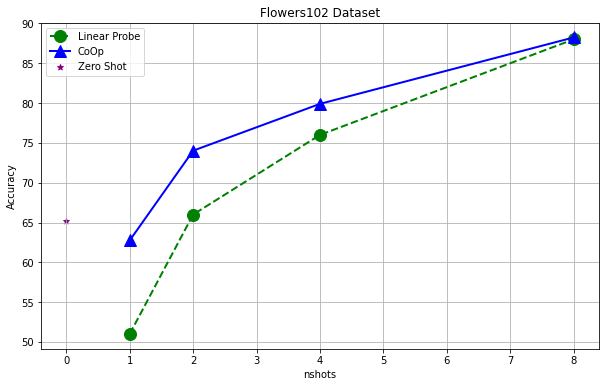

In [ ]:
nshots = [1,2,4,8]

# average accuracies 
zero_shot = [65.136]

linear_probe = [51,66,76,88]
coop = [62.75, 74.02,79.9,88.24]

cocoop = [61.2,69.6100,76.4700,84.8000]


plt.figure(figsize=(10,6))
plt.plot(nshots,linear_probe, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12,label="Linear Probe")
plt.plot(nshots,coop, color='blue', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.scatter([0],zero_shot,color='purple',marker="*",label="Zero Shot")
plt.legend()
plt.title('Flowers102 Dataset')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

# Context Optimization 

### CoCoOp

In [ ]:
class CoCoOp(nn.Module):
    def __init__(self, cfg, model, device):
        super().__init__()
        self.n_cls = len(cfg.DATASET.CLASSNAMES)
        self.n_ctx = cfg.TRAIN.N_CTX
        self.dtype = model.dtype
        ctx_dim = model.ln_final.weight.shape[0]
        vis_dim = model.visual.output_dim
        # img_dim = model.visual.input_resolution
        
        # prompt in CoCoOp with classname at the back looks like: [SOS][V1]...[Vn][CLS][EOS]
        
        # context init (always global in cocoop)
        if cfg.TRAIN.CTX_INIT:
            # fixed init
            ctx_init = cfg.TRAIN.CTX_INIT.replace("_", " ") # The "_" is for fill-in of class name
            with torch.no_grad():
                token_emb = model.token_embedding(clip.tokenize(ctx_init).to(device)).type(model.dtype)
            ctx_vectors = token_emb[0, 1:self.n_ctx+1, :]
            prefix = ctx_init
        else:
            # random init
            ctx_vectors = torch.empty(self.n_ctx, ctx_dim, dtype=model.dtype)
            nn.init.normal_(ctx_vectors, std=cfg.TRAIN.PARAM_STD)
            prefix = " ".join(["X"]*self.n_ctx)
        
        # context vectors
        self.ctx = nn.Parameter(ctx_vectors)      
          
        # FF (image -> ctx bias)
        self.net = nn.Sequential(
            nn.Linear(vis_dim, vis_dim//16),
            nn.ReLU(inplace=True),
            nn.Linear(vis_dim//16, ctx_dim)
        )
        
        # prompt finalization
        classnames = [classname.replace("_", " ") for classname in cfg.DATASET.CLASSNAMES]
        raw_prompts = [prefix + " " + classname + "." for classname in classnames]
        self.tokenized_prompts = torch.cat([clip.tokenize(raw_prompt).to(device) for raw_prompt in raw_prompts])
        with torch.no_grad():
            token_emb = model.token_embedding(self.tokenized_prompts).type(model.dtype)
        
        # [SOS]
        self.register_buffer("prefix", token_emb[:, :1, :])
        # [CLS][EOS]
        self.register_buffer("suffix", token_emb[:, self.n_ctx+1:, :])
        
    def forward(self, img_feats):
        bias = self.net(img_feats.type(torch.float32)).unsqueeze(1).type(self.dtype) # (batch, 1, dim)
        ctx = self.ctx
        ctx = ctx.unsqueeze(0).to(device)                  # (1, n_ctx, dim)
        ctx_shifted = ctx + bias                # (batch, n_ctx, dim)
        
        prompt_embs = []
        for ctx_shifted_i in ctx_shifted:
            ctx_i = ctx_shifted_i.unsqueeze(0).expand(self.n_cls, -1, -1)

            prompt_emb = torch.cat(
                [
                    self.prefix,    # (n_cls, 1, dim)
                    ctx_i,          # (n_cls, n_ctx, dim)
                    self.suffix     # (n_cls, sfx_len, dim)
                ], dim=1
            )
            
            prompt_embs.append(prompt_emb)
        
        return torch.stack(prompt_embs)

## Custom Model

In [ ]:
class CustomCLIPCoCoOp(nn.Module):
    def __init__(self, cfg, model,device):
        super().__init__()
        self.prompt_learner = CoCoOp(cfg, model,device)
        self.model = model
        
        # The freezing part was originally done in the training part, but why not just here since we are not modifying anything of CLIP anyway?
        for _,param in self.model.named_parameters():
            param.requires_grad = False
    
    # note that this is nearly identical to the model.encode_text() function from CLIP
    # the only difference is that we already have prompt_embs rather than having to recompute it
    def encode_text(self, prompt_embs, tokenized_prompts):
        x = prompt_embs + self.model.positional_embedding.type(self.model.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.model.ln_final(x).type(self.model.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.model.text_projection
        return x
    
    def forward(self, img_feats):
        logit_scale = self.model.logit_scale.exp()
        tokenized_prompts = self.prompt_learner.tokenized_prompts
        prompt_embs = self.prompt_learner(img_feats)
        
        # normalize
        img_feats = img_feats/img_feats.norm(dim=-1, keepdim=True).type(self.model.dtype)   # It was float16 but model.dtype = float32.
        
        logits = []
        for pts_i, img_i in zip(prompt_embs, img_feats):
            txt_feats = self.encode_text(pts_i, tokenized_prompts)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            l_i = logit_scale * img_i @ txt_feats.t()
            logits.append(l_i)

        return torch.stack(logits)

In [ ]:
# def test():
#   img_embs, lbls = torch.load(f'checkpoints/{cfg.DATASET.NAME}_image_embs.pt'), torch.load(f'checkpoints/{cfg.DATASET.NAME}_labels.pt')
#   print("Original Dataset:\t ",img_embs.shape, lbls.shape, '\n')

#   m = CustomCLIPCoCoOp(cfg, model, device)
#   m.to(device)

#   print(m(img_embs[0].unsqueeze(0).to(device)).shape)

# test()

Original Dataset:	  torch.Size([1020, 1024]) torch.Size([1020]) 

torch.Size([1, 102])


### Results

In [ ]:
# define nshot
from utils import build_lr_scheduler

img_embs, lbls = torch.load(f'checkpoints/{cfg.DATASET.NAME}_image_embs.pt'), torch.load(f'checkpoints/{cfg.DATASET.NAME}_labels.pt')
print("Original Dataset:\t ",img_embs.shape, lbls.shape, '\n')
for nshot in [2,4,8]:
    model = CustomCLIPCoCoOp(cfg, clip.load(cfg.MODEL.NAME)[0],device)
    model.to(device)

    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.SGD(model.prompt_learner.parameters(), lr=cfg.OPTIM.LR)
    scheduler = build_lr_scheduler(optimizer, cfg.OPTIM)
    print('_'*40)
    print(f"Subset Dataset: Considering n-shot = {nshot}\n")
    train_img_emb, train_label, test_img_emb, test_label = subset_data(img_embs,lbls,nshot = nshot,test_size = 2,n_classes = len(cfg.DATASET.CLASSNAMES))
    print()

    train_dataloader = DataLoader(TensorDataset(train_img_emb.detach(),train_label), batch_size=4, shuffle=True)
    test_dataloader = DataLoader(TensorDataset(test_img_emb.detach(),test_label), batch_size=4, shuffle=False)

    train(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, n_epoch=30)

Original Dataset:	  torch.Size([1020, 1024]) torch.Size([1020]) 

________________________________________
Subset Dataset: Considering n-shot = 2

Test set:  torch.Size([204, 1024]) torch.Size([204])
Train set:  torch.Size([204, 1024]) torch.Size([204])

-------------------- Train results --------------------

Epoch 1/30:
--------------------
loss: 4.3987; acc: 22.0600 %

Epoch 5/30:
--------------------
loss: 1.2112; acc: 71.0800 %

Epoch 10/30:
--------------------
loss: 0.9604; acc: 76.4700 %

Epoch 15/30:
--------------------
loss: 0.7400; acc: 84.3100 %

Epoch 20/30:
--------------------
loss: 0.5333; acc: 88.2400 %

Epoch 25/30:
--------------------
loss: 0.4114; acc: 92.6500 %

Epoch 30/30:
--------------------
loss: 0.2802; acc: 97.5500 %

 -------------------- Eval results --------------------
loss: 1.1670; acc: 69.6100
________________________________________
Subset Dataset: Considering n-shot = 4

Test set:  torch.Size([204, 1024]) torch.Size([204])
Train set:  torch.Size([4